Our prediction target for the regression is the mass attribute, as we stated it in our previous report. The mass will be predicted based on the following attributes: distance, stellar_magnitude, orbital_radius, orbital_period, eccentricity and radius attributes. This choice is based on our previous analysis and research of the dataset where we found that the mass could potentially have a high importance in predicting the planet type which we predict for our classification task.
Sources: 
- https://www.kaggle.com/code/suhanikulshrestha02/exoplanet-characterization-using-ml
- https://www.kaggle.com/code/mikedelong/looking-for-earth-like-planets-with-scatter-plots

Additionally, the mass attribute was found to be less correlated with other variables than most other attributes (e.g. orbital period and orbital radius) which makes it a more interesting target for our Neural Network regression.
[Correlation Matrix relevant part could be added...]

In order to make our data suitable for regression tasks, we needed to do a few transformations. First of all, the mass attribute was stored in 2 separate attributes: mass_wrt, and mass_multiplier. This way the mass was always stored relative to Earth or Jupiter in the original dataset. To unify this, we converted the masses to kg and created a single mass variable. The same process was repeated for the radius_multiplier and radius_wrt attributes.

Some attributes were excluded, as their meaning is not clear for such a task: Even though detection_method, and discovery_year is part of our attribute list, it is not aligned with our objective as it is not a planetary characteristic, more of an artifact of the observation and categorization. Because of this reason such variables were considered to be irrelevant for this task.
Moreover the attribute orbital_period was also excluded from the list of attributes because of its extreme correlation with orbital_radius. Based on some test runs with including this attribute we found that this makes the model unstable, possibly due to both of the attributes pushing the model in the same direction and distorting the importance of the features.

We decided to include planet_type in our attributes, as it can serve as a useful indicator of the plant properties. We needed to transform this variable because of its categorical nature. For this we used one of K encoding, so that each planet type has its own column in the data.


After these preparatory steps we standardized the data. It is important to highlight here that for the regression task both our features and our target variable was standardized. This choice was based on the scale of our mass attribute, which due to being calculated in kg-s, moves around the range of 10^20. This can lead into anomalies during the training (calculations with such numbers could more easily lead into overflows). We made sure to only standardize the numerical attributes, and leave the one of K encoded planet types as is.
Wherever we used cross-validation, we made sure to do the standardization for each fold separately, to get accurate and fair results for the model.

Another important point is that the training and validation data has been standardized separately. This is to make sure that no information from the validation set leaks into the training set, which could happen if we standardize the whole dataset beforehand. In such scenario the mean and the variance is calculated on the whole dataset too which includes the samples from the validation set. Thus the model would be able to access this information indirectly based on the new scale of the training data.

Our aim is to compare multiple methods for the regression task to see which one performs the best. Whenever we evaluate the optimal model, we use a separate validation set.
First, we ran a linear regression model with a 10 fold cross validation setup to see if it can capture the relationship between the data. Our goal



In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [115]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape

(4765, 13)

In [116]:
num_obeservation = 4000
df = clean_dataset.iloc[range(num_obeservation)]
full_df = df.copy()
df = df.drop("name", axis=1)

In [117]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
4260    7849.0           16.06200  Neptune-like            2016   
4261    3197.0           14.67200  Neptune-like            2016   
4262    2942.0           15.57600  Neptune-like            2016   
4263    3601.0           15.42400  Neptune-like            2016   
4264    3081.0           13.69300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

In [118]:
outlier = df.iloc[np.where(df["mass"] > 10**30)]
df = df.drop(outlier.index)
df.shape

(3999, 10)

In [119]:
# columns_to_log = ["distance", "orbital_period", "orbital_radius", "radius", "mass"]
# # columns_to_log = ["mass"]
# for col in columns_to_log:
#     df[col] = np.log10(df[col])

In [120]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes
encoded_df["discovery_year"] = encoded_df["discovery_year"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method", "discovery_year"] , axis=1)

In [121]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories)
discovery_cats = df["discovery_year"].astype("category")
print(discovery_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Orbital Brightness Modulation',
       'Radial Velocity', 'Transit', 'Transit Timing Variations'],
      dtype='object')
Index([1995, 1996, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023],
      dtype='int64')


In [122]:
df_train = df_without_type.copy().drop("orbital_period", axis=1)
df_train["planet_type"] = df["planet_type"]
df_train = pd.get_dummies(df_train, columns=['planet_type'])

df_train

,distance,stellar_magnitude,orbital_radius,eccentricity,mass,radius,planet_type_Gas Giant,planet_type_Neptune-like,planet_type_Super Earth,planet_type_Terrestrial
0,304.0,4.72307,1.290000,0.23,3.682120e+28,75503.880,True,False,False,False
1,409.0,5.01300,1.530000,0.08,2.797652e+28,76202.990,True,False,False,False
2,246.0,5.23133,0.830000,0.00,9.110400e+27,80397.650,True,False,False,False
3,58.0,6.61935,2.773069,0.37,1.544746e+28,78300.320,True,False,False,False
4,69.0,6.21500,1.660000,0.68,3.378440e+27,83893.200,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
4260,7849.0,16.06200,0.107000,0.00,4.897040e+25,17407.839,False,True,False,False
4261,3197.0,14.67200,0.101300,0.00,4.717880e+25,17058.284,False,True,False,False
4262,2942.0,15.57600,0.114400,0.00,4.228176e+25,15939.708,False,True,False,False
4263,3601.0,15.42400,0.126600,0.00,4.717880e+25,17058.284,False,True,False,False


In [123]:
# Define features, and target variable
X = df_train.drop(columns=['mass']).values
y = df_train['mass'].values
print(X.shape, y.shape)

(3999, 9) (3999,)


In [124]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def standardize_data(X_train_orig, X_test_orig, y_train_orig, y_test_orig, numerical_indices, encoded_indices):

    # Scale Numerical Features
    X_train_numerical = X_train_orig[:, numerical_indices]
    X_test_numerical = X_test_orig[:, numerical_indices]

    feature_scaler = StandardScaler()
    X_train_scaled_numerical = feature_scaler.fit_transform(X_train_numerical)
    X_test_scaled_numerical = feature_scaler.transform(X_test_numerical)

    # Recombine scaled numerical + encoded parts
    X_train_scaled = np.concatenate([X_train_scaled_numerical, X_train_orig[:, encoded_indices]], axis=1)
    X_test_scaled = np.concatenate([X_test_scaled_numerical, X_test_orig[:, encoded_indices]], axis=1)

    # Scale Target Variable
    mu_y = y_train_orig.mean()
    sigma_y = y_train_orig.std()
    epsilon = 1e-8

    y_train_scaled = (y_train_orig - mu_y) / (sigma_y + epsilon)
    y_test_scaled = (y_test_orig - mu_y) / (sigma_y + epsilon)

    return X_train_scaled.astype(np.float32), X_test_scaled.astype(np.float32), y_train_scaled, y_test_scaled, feature_scaler, mu_y, sigma_y


In [ ]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [126]:
lambdas = np.logspace(-6, 4, 100)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

train_errors = []
test_errors = []
coeff = []

In [127]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler # Import the scaler

# Define column indices
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# A safety check in case there are no numerical columns
has_numerical_features = len(numerical_indices) > 0

for lam in lambdas:
    
    fold_train_errors = []
    fold_test_errors = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize processed arrays with the one-hot encoded parts
        X_train, X_test, y_train, y_test, a, b, c = standardize_data(
            X_train, X_test, y_train, y_test,
            numerical_indices, encoded_indices
        )

        # Fit the model on the correctly processed data
        ridge = Ridge(alpha=lam)
        ridge.fit(X_train, y_train)
        
        y_pred_train = ridge.predict(X_train)
        y_pred_test = ridge.predict(X_test)
        
        fold_train_errors.append(mean_squared_error(y_train, y_pred_train))
        fold_test_errors.append(mean_squared_error(y_test, y_pred_test))
    
    train_errors.append(np.mean(fold_train_errors))
    test_errors.append(np.mean(fold_test_errors))
    coeff.append(ridge.coef_)

/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.01057e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.33454e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.01057e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.33454e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.010

In [128]:
#optimal lambda
optimal_idx = np.argmin(test_errors)
optimal_lambda = lambdas[optimal_idx]
optimal_error = test_errors[optimal_idx]
optimal_coeff = coeff[optimal_idx]

print(f"Optimal lambda = {optimal_lambda:.4f}")
print(f"Minimum Cross-Validation error = {optimal_error:.4f}")
print(f"Optimal coefficients = {optimal_coeff}")

Optimal lambda = 3944.2061
Minimum Cross-Validation error = 0.9788
Optimal coefficients = [ 0.01481999 -0.0342379   0.02241286  0.04231808  0.12825069  0.05619033
 -0.03336674 -0.02012915 -0.00269449]


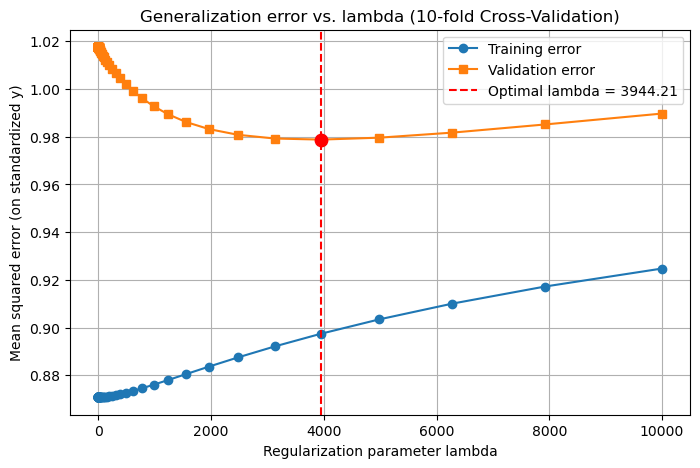

In [129]:

plt.figure(figsize=(8, 5))
plt.plot(lambdas, train_errors, marker='o', label='Training error')
plt.plot(lambdas, test_errors, marker='s', label='Validation error')

# Highlight optimal lambda
plt.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal lambda = {optimal_lambda:.2f}')
plt.scatter(optimal_lambda, optimal_error, color='red', s=80, zorder=5)

# Labels and legend
plt.xlabel('Regularization parameter lambda')
plt.ylabel('Mean squared error (on standardized y)')
plt.title('Generalization error vs. lambda (10-fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.show()

As visible on the plot the linear regression model fails to capture the validation data as well as the train data. There is a visible difference on the validation and the training error. This indicates overfitting on the training set, as the model is not able to generalize the knowledge to the validation set, this means that the parameters of the model are tuned to the data it was trained on. 

Our conclusion is that linear regression is not the best approach for our problem.
This is a logical result when we look deeper into the attributes: The mass is not in a linear relationship with the other attributes. As it is also stated in Kepler's laws (which can be used for planet mass estimation if there is a moon or a spacecraft in orbit of the planet): https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion the relationship between some of these attributes is already quadratic or third degree. Additionally, there is no clear equation that would describe the relationships between our input and target attributes directly.

At the same time it is also observable that regularization helps with limiting the generalization error. As we increase lambda, the generalization error drops, then starts increasing while the training error steadily increases as we include higher and higher lambdas. This is a direct consequence of how regularization is applied, as it "forces" the weights away from the overfitting solution. However, if the lambda parameter is too high, it prevents the model from capturing the data ans the proportion of the regularization penalty in the error becomes the dominant factor.
[Formula for regularization]

Linear regression aims to fit a linear combination of the input features to capture the output feature: f(x,w) = w0 +
w1x1+· · ·+wMxM.
Now we go deeper into our optimal linear model by looking at the coefficients. These show how the individual attributes are weighted in the linear regression model.

In [99]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define the column indices for numerical and encoded features
total_columns = X.shape[1]
numerical_indices = list(range(total_columns - 4))
encoded_indices = list(range(total_columns - 4, total_columns))

# Isolate the numerical parts from the new splits
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, feature_scaler, mu_y, sigma_y = standardize_data(
    X_train_orig, X_test_orig, y_train_orig, y_test_orig,
    numerical_indices, encoded_indices
)


print("--- Final Model Training ---")
print(f"Using optimal lambda: {optimal_lambda}")

# Initialize the model with the best lambda
ridge = Ridge(alpha=optimal_lambda)
ridge.fit(X_train_scaled, y_train_scaled)

# Store the final coefficients and intercept
coeffs = ridge.coef_
intercept = ridge.intercept_

# Make predictions on the scaled training and test sets
y_pred_train_scaled = ridge.predict(X_train_scaled)
y_pred_test_scaled = ridge.predict(X_test_scaled)

train_error_scaled = mean_squared_error(y_train_scaled, y_pred_train_scaled)
test_error_scaled = mean_squared_error(y_test_scaled, y_pred_test_scaled)

print(f"\nFinal training MSE (on scaled data): {train_error_scaled:.4f}")
print(f"Final test MSE (on scaled data): {test_error_scaled:.4f}")
print(f"\nModel Coefficients: {coeffs}")
print(f"Model Intercept: {intercept}")

--- Final Model Training ---
Using optimal lambda: 3944.206059437648

Final training MSE (on scaled data): 0.8984
Final test MSE (on scaled data): 0.5984

Model Coefficients: [ 0.01167802 -0.04074212  0.02148007  0.0471864   0.12193159  0.05354385
 -0.03126898 -0.01964409 -0.0026307 ]
Model Intercept: 0.00392483314499259


Ridge Regression Coefficients:
                 Feature  Coefficient
                  radius     0.121932
   planet_type_Gas Giant     0.053544
            eccentricity     0.047186
       stellar_magnitude    -0.040742
planet_type_Neptune-like    -0.031269
          orbital_radius     0.021480
  planet_type_SuperEarth    -0.019644
                distance     0.011678
 planet_type_Terrestrial    -0.002631

Intercept: 0.0039
Train Error (MSE): 0.8984
Test Error (MSE): 0.5984


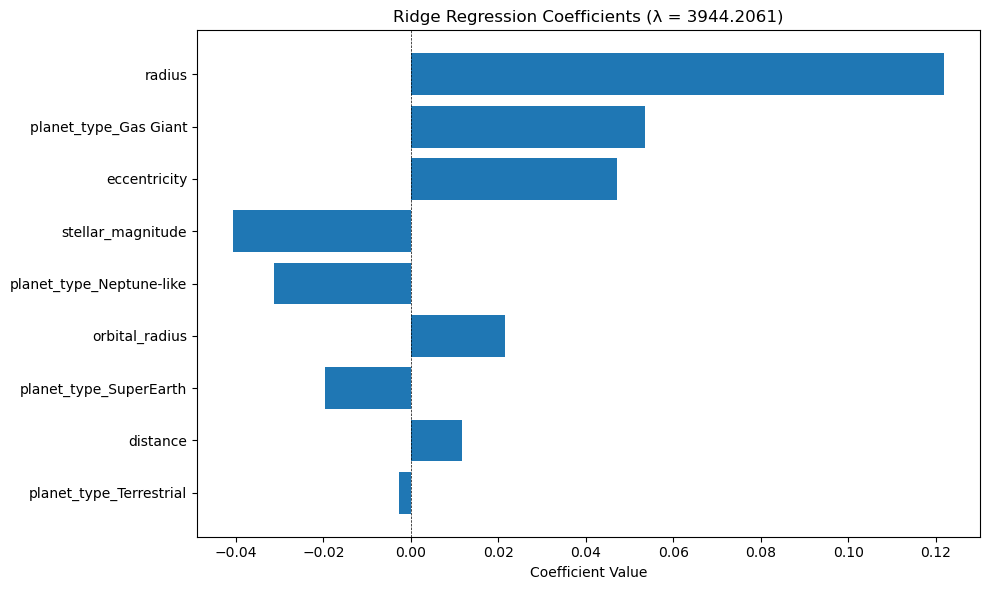

,Feature,Coefficient
4,radius,0.121932
5,planet_type_Gas Giant,0.053544
3,eccentricity,0.047186
1,stellar_magnitude,-0.040742
6,planet_type_Neptune-like,-0.031269
2,orbital_radius,0.021480
7,planet_type_SuperEarth,-0.019644
0,distance,0.011678
8,planet_type_Terrestrial,-0.002631


In [100]:


# Feature names for regression (excluding 'mass' which is the target)
feature_names_planets = ['distance', 'stellar_magnitude', 'orbital_radius', 'eccentricity', 'radius', 'planet_type_Gas Giant', 'planet_type_Neptune-like', 'planet_type_SuperEarth', 'planet_type_Terrestrial']
#feature_names = ['distance', 'stellar_magnitude', 'orbital_radius', 'eccentricity', 'radius']

# Create DataFrame for coefficients
coeffs_df = pd.DataFrame({
    'Feature': feature_names_planets,
    'Coefficient': coeffs
}).sort_values('Coefficient', key=abs, ascending=False)

print("Ridge Regression Coefficients:")
print(coeffs_df.to_string(index=False))
print(f"\nIntercept: {intercept:.4f}")
print(f"Train Error (MSE): {train_error_scaled:.4f}")
print(f"Test Error (MSE): {test_error_scaled:.4f}")

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coeffs_df['Feature'], coeffs_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title(f'Ridge Regression Coefficients (λ = {optimal_lambda:.4f})')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display the DataFrame
coeffs_df

As we observable on the plot there are clearly a few attributes that have a higher (in absolute value) coefficient. The most dominant is the coefficient for the radius. This is in line with our previous analysis, where we investigated the correlation between different numerical attributes. Here we observed that the target attribute (mass) has the strongest correlation with the radius attribute. The other 5 coefficients are signifcantly smaller which is again in sync with the observations from our correlation.
[correlation matrix comparison]

Moreover, it is also an interesting finding that the planet types have a meaningful influence. Particularly, the gas giants have a strong negative influence. This is in line with the expectation that gas giants have a smaller density than rocky planets. (https://pmc.ncbi.nlm.nih.gov/articles/PMC4156706/). As a direct consequence for such large gas planets the radius is going to be also large, but the information on its type 'rebalances' the weight estimation in the regression model with a strong negative direction: as the type also indirectly indicates that the planet is likely to have a smaller density. On the other hand it is clearly visible for the rocky planets that their type adds a positive nudge to the weight estimation, as their density is a lot higher.

We conclude that the coefficients are in line with our expectations which is also supported by our previous findings regarding the radius and literature on the planet types.

In [101]:
K1 = 10  # outer folds
K2 = 10  # inner folds

# Regularization and ANN hyperparameters
lambdas = np.logspace(-6, 4, 50)
hidden_units = [1, 8, 16, 32, 64, 128]

In [102]:
# Storage
test_errors_outer = {
    'baseline': np.zeros(K1),
    'ridge': np.zeros(K1),
    'ann': np.zeros(K1),
    # 'deep_ann': np.zeros(K1)
}
y_true = []
y_preds = {
    'baseline': [],
    'ridge': [],
    'ann': [],
    # 'deep_ann': []
}

In [103]:
optimal_hs = np.zeros(K1)
optimal_hs_deep = np.zeros(K1)
optimal_lambdas = np.zeros(K1)

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class PredictorANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(PredictorANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [105]:
# Deep architecture with 3 hidden layers
class DeepANN(nn.Module):
    def __init__(self, input_dim, hidden_units):
        super(DeepANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, x):
        return self.model(x)

In [106]:
def train_custom_ann(X_train, y_train, X_val, y_val, hidden_units, 
                      lr=1e-8, weight_decay=0.0, epochs=10, batch_size=32, verbose=False, deep=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Convert numpy arrays to torch tensors
    
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32).to(device)

    # Datasets and loaders
    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Initialize model, loss, optimizer
    
    if deep:
        model = DeepANN(X_train.shape[1], hidden_units).to(device)
    else:
        model = PredictorANN(X_train.shape[1], hidden_units).to(device)
        
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
        step_val_loss = criterion(model(X_val_t), y_val_t).item()
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {step_val_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_t)
        val_loss = criterion(val_preds, y_val_t).item()

    # print(f"Validation Loss: {val_loss:.4f}")
    return val_loss, model


In [107]:
train_custom_ann(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_units=32, 
                      lr=1e-3,epochs=20, batch_size=32, deep=True)

(0.431125283241272,
 DeepANN(
   (model): Sequential(
     (0): Linear(in_features=9, out_features=32, bias=True)
     (1): ReLU()
     (2): Linear(in_features=32, out_features=32, bias=True)
     (3): ReLU()
     (4): Linear(in_features=32, out_features=32, bias=True)
     (5): ReLU()
     (6): Linear(in_features=32, out_features=1, bias=True)
   )
 ))

In [108]:
# Outer cross-validation loop
from sklearn.neural_network import MLPRegressor


outer_cv = KFold(K1, shuffle=True, random_state=42)

for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(X, y)):
    print(f"Outer fold {outer_fold + 1}/{K1}")

    X_train_outer, y_train_outer = X[outer_train_idx], y[outer_train_idx]
    X_test_outer, y_test_outer = X[outer_test_idx], y[outer_test_idx]

    # Standardize (based on training data)
    X_train_outer, X_test_outer, y_train_outer, y_test_outer, feature_scaler, mu_y, sigma_y = standardize_data(
        X_train_outer, X_test_outer, y_train_outer, y_test_outer,
        numerical_indices, encoded_indices
    )

    # BASELINE MODEL
    y_pred_baseline = np.full_like(y_test_outer, np.mean(y_train_outer))
    test_errors_outer['baseline'][outer_fold] = np.mean((y_test_outer - y_pred_baseline) ** 2)
    y_preds['baseline'].append(y_pred_baseline)

    #INNER CV for Ridge
    inner_cv = KFold(K2, shuffle=True, random_state=42)
    ridge_val_errors = np.zeros(len(lambdas))

    for i, lam in enumerate(lambdas):
        inner_errors = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            model = Ridge(alpha=lam)
            model.fit(X_train_inner, y_train_inner)
            y_val_pred = model.predict(X_val_inner)
            inner_errors.append(mean_squared_error(y_val_inner, y_val_pred))
        ridge_val_errors[i] = np.mean(inner_errors)

    optimal_lambda = lambdas[np.argmin(ridge_val_errors)]
    optimal_lambdas[outer_fold] = optimal_lambda

    # Train Ridge on full outer training set
    ridge_model = Ridge(alpha=optimal_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_pred = ridge_model.predict(X_test_outer)
    ridge_test_error = np.mean((y_test_outer - ridge_pred) ** 2)
    test_errors_outer['ridge'][outer_fold] = ridge_test_error
    y_preds['ridge'].append(ridge_pred)

    # ----- INNER CV for ANN (PyTorch version) -----
    ann_val_errors = np.zeros(len(hidden_units))
    ann_val_errors_deep = np.zeros(len(hidden_units))

    for j, h in enumerate(hidden_units):
        inner_errors = []
        inner_errors_deep = []
        for train_idx, val_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_idx], X_train_outer[val_idx]
            y_train_inner, y_val_inner = y_train_outer[train_idx], y_train_outer[val_idx]

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner, hidden_units=h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=False)
            inner_errors.append(val_loss)

            val_loss, _ = train_custom_ann(X_train_inner, y_train_inner, X_val_inner, y_val_inner, hidden_units=h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=True)
            inner_errors_deep.append(val_loss)

        ann_val_errors[j] = np.mean(inner_errors)
        ann_val_errors_deep[j] = np.mean(inner_errors_deep)

    optimal_h = hidden_units[np.argmin(ann_val_errors)]
    optimal_hs[outer_fold] = optimal_h

    optimal_h_deep = hidden_units[np.argmin(ann_val_errors_deep)]
    optimal_hs_deep[outer_fold] = optimal_h_deep

    # Train final ANN model on full outer training set
    # _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer,
    #                                 hidden_units=optimal_h, lr=1e-3, epochs=10)
    _, ann_model = train_custom_ann(X_train_outer, y_train_outer, X_test_outer, y_test_outer, hidden_units=optimal_h, 
                      lr=1e-3,epochs=20, batch_size=32, deep=False)
    ann_model.eval()

    device = next(ann_model.parameters()).device  # get model’s device
    X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    with torch.no_grad():
        y_pred_t = ann_model(X_test_t).cpu().numpy().flatten()

    ann_test_error = mean_squared_error(y_test_outer, y_pred_t)
    test_errors_outer['ann'][outer_fold] = ann_test_error
    y_preds['ann'].append(y_pred_t)


    # _, ann_model_deep = train_custom_ann(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, hidden_units=optimal_h_deep, 
    #                   lr=1e-3,epochs=20, batch_size=32, deep=True)
    # ann_model_deep.eval()

    # device = next(ann_model_deep.parameters()).device  # get model’s device
    # #X_test_t = torch.tensor(X_test_outer, dtype=torch.float32).to(device)
    # #y_test_t = torch.tensor(y_test_outer.reshape(-1, 1), dtype=torch.float32).to(device)

    # with torch.no_grad():
    #     y_pred_t_deep = ann_model_deep(X_test_t).cpu().numpy().flatten()

    # ann_test_error_deep = mean_squared_error(y_test_outer, y_pred_t_deep)
    # test_errors_outer['deep_ann'][outer_fold] = ann_test_error_deep
    # y_preds['deep_ann'].append(y_pred_t_deep)

    y_true.append(y_test_outer)


# Results summary
print("\nMean test errors across outer folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")

Outer fold 1/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.60473e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.04877e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.60473e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.04877e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.604

Outer fold 2/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.19587e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.56243e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.49768e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.69875e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.110

Outer fold 3/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.58093e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.83334e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.35333e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.58093e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.833

Outer fold 4/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.75696e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.78003e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.05531e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.75696e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.780

Outer fold 5/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.73451e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.73451e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.73451e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.73451e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.734

Outer fold 6/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.80572e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.94143e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=9.13581e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.80572e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.941

Outer fold 7/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.51412e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.0391e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.51412e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.0391e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.51412

Outer fold 8/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.0682e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.52075e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.12408e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.00697e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.7552

Outer fold 9/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.91163e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.93645e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.11841e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89211e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.911

Outer fold 10/10


/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.22712e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.2963e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.25001e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.25012e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/envs/ml_project/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.1984


Mean test errors across outer folds:
baseline  : 1.0586 ± 0.7875
ridge     : 1.0081 ± 0.7731
ann       : 0.8055 ± 0.6091


In [109]:
y_true = np.concatenate(y_true)


In [110]:
y_preds_concat = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

In [111]:
# Summarize Results in Table
results_df = pd.DataFrame({
    'Fold': np.arange(1, K1 + 1),
    'lambda* (Ridge)': optimal_lambdas,
    'h* (ANN)': optimal_hs,
    # 'h* (Deep ANN)': optimal_hs_deep,
    'Baseline Test Error': test_errors_outer['baseline'],
    'Ridge Test Error': test_errors_outer['ridge'],
    'ANN Test Error': test_errors_outer['ann'],
    # 'Deep ANN Test Error': test_errors_outer['deep_ann']
})

# Display the table
print("\n===== Table 1: Cross-Validation Results =====")
print(results_df.to_string(index=False))

# Summary statistics
print("\nMean ± Std of Test Errors across folds:")
for model_name, errors in test_errors_outer.items():
    print(f"{model_name:10s}: {np.mean(errors):.4f} ± {np.std(errors):.4f}")


===== Table 1: Cross-Validation Results =====
 Fold  lambda* (Ridge)  h* (ANN)  Baseline Test Error  Ridge Test Error  ANN Test Error
    1       954.095476     128.0             0.208015          0.147183        0.152786
    2       954.095476     128.0             1.222254          1.128952        0.915967
    3       954.095476     128.0             2.865644          2.604433        2.200663
    4       372.759372      64.0             1.138665          1.747536        0.865748
    5       954.095476     128.0             1.696382          1.538097        1.349084
    6       954.095476     128.0             0.239302          0.182288        0.188178
    7       954.095476     128.0             1.160391          1.030985        0.883909
    8       954.095476     128.0             0.480602          0.366824        0.312820
    9       954.095476     128.0             1.339122          1.176534        0.983381
   10       954.095476     128.0             0.235191          0.158051  

In [112]:
import scipy.stats as st
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):

    # 4.1) Calculate estimated error, z_hat, as the mean loss across all samples
    ### BEGIN SOLUTION
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    ### END SOLUTION
    
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # 4.2) Insert solution from task 3.6 here
    ### BEGIN SOLUTION
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu))) # or st.sem(loss_fn(y_true, y_preds))
    ### END SOLUTION
    
    # 4.3) Insert solution from task 3.7 here
    ### BEGIN SOLUTION
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval
    ### END SOLUTION

    # 4.4) Calculate the p-value for the two-sided test using the t-distribution
    ### BEGIN SOLUTION
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)  # p-value
    ### END SOLUTION

    return z_hat, CI, p_value

In [113]:
l2_loss = lambda y, y_pred: (y - y_pred)**2
alpha = 0.05

setup1_storage = {
    'ridge_ann': [],
    'ann_baseline': [],
    'ridge_baseline': []
}

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["ann"], l2_loss, alpha=alpha)
setup1_storage['ridge_ann'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and ANN: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ridge"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ridge_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between Ridge and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

z_hat, CI, p_value = confidence_interval_comparison(y_true, y_preds_concat["ann"], y_preds_concat["baseline"], l2_loss, alpha=alpha)
setup1_storage['ann_baseline'].append((z_hat, CI, p_value))
print(f"Difference in loss between ANN and Baseline: \nz_hat: {z_hat:.4f}, \nCI: [{CI[0]:.4f}, {CI[1]:.4f}], \np-value: {p_value}")

Difference in loss between Ridge and ANN: 
z_hat: 0.2027, 
CI: [0.0263, 0.3791], 
p-value: 0.024299747140180357
Difference in loss between Ridge and Baseline: 
z_hat: -0.0505, 
CI: [-0.1977, 0.0968], 
p-value: 0.5016897833479742
Difference in loss between ANN and Baseline: 
z_hat: -0.2532, 
CI: [-0.3935, -0.1128], 
p-value: 0.0004108232332976945
